# Q2.1 - Lasso regression model with l1 regularization on the dataset

In [1]:
# ============================================================
# Q 2.1  ·  Logistic-Lasso (leak-proof, ready-to-run)
#         – requires: scikit-learn, numpy, pandas, joblib
#         – uses the *original* preprocessor.pkl from Q1.3
# ============================================================

import numpy as np
import pandas as pd
import joblib
from pathlib import Path

# ─────────────────────────────────────────────────────────────
# 0)  RE-DECLARE  KNNAndScaledBounds  (needed for un-pickling)
# ─────────────────────────────────────────────────────────────
from sklearn.base        import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.impute      import KNNImputer

class KNNAndScaledBounds(BaseEstimator, TransformerMixin):
    """Scale → KNN-impute → clip (in scaled coords) → un-scale."""
    def __init__(self, n_neighbors=8, raw_min_dict=None):
        self.n_neighbors  = n_neighbors
        # default minima: RestingBP≥50, Cholesterol≥70, Oldpeak≥0
        self.raw_min_dict = raw_min_dict or {1: 50, 2: 70, 4: 0}

    # --------------------
    def fit(self, X, y=None):
        self.n_features_ = X.shape[1]
        self.scaler_     = StandardScaler().fit(X)
        Xs               = self.scaler_.transform(X)

        self.imputer_    = KNNImputer(n_neighbors=self.n_neighbors).fit(Xs)

        # pre-compute scaled minima
        self.scaled_min_ = {i: (v - self.scaler_.mean_[i]) / self.scaler_.scale_[i]
                            for i, v in self.raw_min_dict.items()}
        return self

    # --------------------
    def transform(self, X, y=None):
        if X.shape[1] != self.n_features_:
            raise ValueError("Mismatch in #features")
        Xs  = self.scaler_.transform(X)
        Xsi = self.imputer_.transform(Xs)
        for i, zmin in self.scaled_min_.items():
            Xsi[:, i] = np.clip(Xsi[:, i], zmin, None)
        return self.scaler_.inverse_transform(Xsi)

# ─────────────────────────────────────────────────────────────
# 1)  DATA  +  (now un-picklable)  PRE-PROCESSOR
# ─────────────────────────────────────────────────────────────
df        = pd.read_csv("train_val_split.csv")
X, y      = df.drop(columns=["HeartDisease"]), df["HeartDisease"]
prep_path = Path("preprocessor.pkl")

if not prep_path.exists():
    raise FileNotFoundError("preprocessor.pkl not found – make sure Q1.3 ran OK.")

prep = joblib.load(prep_path)          # UN-fitted template

# ─────────────────────────────────────────────────────────────
# 2)  PIPELINE  (prep ➊  →  LogisticRegression + L1 ➋)
# ─────────────────────────────────────────────────────────────
from sklearn.pipeline   import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics    import make_scorer, balanced_accuracy_score

pipe = Pipeline([
    ("prep", prep),                            # fresh fit in every CV fold
    ("clf",  LogisticRegression(
                penalty      = "l1",
                solver       = "saga",         # supports L1 + class_weight
                class_weight = "balanced",
                max_iter     = 8000,
                random_state = 42))
])

param_grid = {"clf__C": np.logspace(-3, 2, 12)}   # 0.001 … 100
cv   = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(pipe,
                    param_grid,
                    scoring = make_scorer(balanced_accuracy_score),
                    cv      = cv,
                    n_jobs  = -1,
                    verbose = 0)

grid.fit(X, y)

# ─────────────────────────────────────────────────────────────
# 3)  RESULTS
# ─────────────────────────────────────────────────────────────
best_C   = grid.best_params_["clf__C"]
best_bal = grid.best_score_
clf      = grid.best_estimator_.named_steps["clf"]
coef_vec = clf.coef_.flatten()

print(f"\nBest C                 : {best_C}")
print(f"CV balanced accuracy   : {best_bal:.3f}")
print(f"Total coefficients     : {coef_vec.size}")
print(f"Coefficients zeroed    : {(coef_vec == 0).sum()}")

# ─────────────────────────────────────────────────────────────
# 4)  SAVE  (pickles both the fitted pre-processor + classifier)
# ─────────────────────────────────────────────────────────────
out_path = "logreg_l1.pkl"
joblib.dump(grid.best_estimator_, out_path)
print(f"\nSaved leak-proof pipeline → {out_path}")


Best C                 : 0.5336699231206307
CV balanced accuracy   : 0.867
Total coefficients     : 14
Coefficients zeroed    : 2

Saved leak-proof pipeline → logreg_l1.pkl


### Q 2.1 – Fit a Logistic-Lasso classifier

* **Pipeline**  
  `raw data → preprocessor.pkl (immutable) → LogisticRegression (L1)`

* **Hyper-parameters**  
  `C ∈ {0.001 … 100}` tuned with 5-fold CV on **balanced accuracy**  
  `solver='saga'`, `class_weight='balanced'`, `max_iter=8000`.

* **Result**  
  *Best C* = **0.534**   •   CV balanced-accuracy = **0.867**  
  14 total coefficients → **2 zeroed** by the ℓ1 penalty (≈ 14 % sparsity)  
  → **12 non-zero features** drive the model’s predictions.

➤ **Why _not_ Group-Lasso?**  
One-hot columns that originate from a single clinical variable really belong together (dropping some but not the rest can distort interpretation).  
A *group-lasso* (or sparse-group-lasso) penalty would keep / drop whole dummy blocks, but every Python package we tested (`group_lasso`, `groupyr`, `lightning`) consistently failed to run in the course environment.  
We therefore settled on a plain Logistic-Lasso and interpret its zeroed coefficients with caution.

Keeping the classifier **inside the same pipeline** as the frozen pre-processor guarantees leak-free cross-validation and gives a single picklable object (`logreg_l1.pkl`) that can be reused in later questions.

## Q 2.2 – What we **must** do before throwing L1 at the data  

When a logistic-lasso shrinks weights, it doesn’t know (or care) that “mm Hg” and “mg/dl” aren’t on the same ruler.  
If we want to read the coefficients like a leaderboard, we have to play fair first.

| Step | Why it’s non-negotiable | How I handled it |
|------|------------------------|------------------|
| **Scale every number** | A one-unit change in *Age* (range 30–80) is tiny compared with a one-unit change in *Oldpeak* (range 0–6). Without scaling, the penalty squashes the wide-ranged features more than the narrow ones. | Two `StandardScaler`s:<br>① *before* KNN so the distance metric makes sense.<br>② *after* cleaning so the model sees honest z-scores. |
| **One-hot the categoricals** | L1 works on columns. Turning “ChestPainType = TA” into a 0 / 1 flag puts it on the same footing as the z-scored numerics and lets me read its β as “log-odds shift vs. baseline”. | `OneHotEncoder(drop='first')` inside the pipeline. |
| **Fill the holes sensibly** | Missing values (or crazy negatives) inflate variance and warp scaling — that misguides the penalty. | KNN-imputation **in scaled space** followed by a hard floor (`RestingBP ≥ 50`, `Chol ≥ 70`, `Oldpeak ≥ 0`). |
| **Re-scale after fixing** | Centered, unit-variance columns mean the intercept now describes a “typical” patient (all features at their mean/baseline) – an interpretable launch-pad. | Final `StandardScaler` step right before the classifier. |

**In short:** the regulariser shouldn’t punish columns merely because they’re measured on a bigger ruler. After these steps a larger |β| really means “more predictive”, not “we forgot to divide by 100”.

---

**Side notes**

* **Collinearity:** If two dummies are near-perfect twins, L1 can flip-flop which one it keeps. Grouping or dropping redundant categories (or switching to elastic-net) steadies the ship.  
* **Class weights:** Balancing the loss (`class_weight='balanced'`) evens out the minority class but doesn’t change coefficient comparability – so I treat it separately.  

*Footnote:* *Ideally we would solve the “dummy-twins” issue with a group-lasso penalty, but see the methodological caveat in Q 2.1.*

# Q2.3 · Quantify the Logistic‑Lasso’s performance

In [2]:
# =========================================================
# Q2.3 · Quantify the Logistic‑Lasso’s performance
#      (balanced‑accuracy  &  macro‑F1)
# =========================================================
import joblib, pandas as pd
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, balanced_accuracy_score, f1_score

# ---------------------------------------------------------
# 1 · Load frozen pipeline + raw data
# ---------------------------------------------------------
pipe = joblib.load("logreg_l1.pkl")             # full Prep ⟶ Lasso pipeline
df   = pd.read_csv("train_val_split.csv")

X = df.drop(columns=["HeartDisease"])
y = df["HeartDisease"]

# ---------------------------------------------------------
# 2 · Cross‑validate *inside* the pipeline
# ---------------------------------------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "bal_acc": make_scorer(balanced_accuracy_score),
    "macro_f1": make_scorer(f1_score, average="macro"),
}

cv_res = cross_validate(
    estimator = pipe,
    X         = X,
    y         = y,
    scoring   = scoring,
    cv        = cv,
    n_jobs    = -1,
    verbose   = 0,
    return_train_score = False
)

# ---------------------------------------------------------
# 3 · Print results
# ---------------------------------------------------------
print("---- 5‑fold cross‑validation ----")
for m in scoring:
    mean = cv_res[f"test_{m}"].mean()
    std  = cv_res[f"test_{m}"].std()
    print(f"{m:>9}: {mean:.3f}  ± {std:.3f}")

---- 5‑fold cross‑validation ----
  bal_acc: 0.867  ± 0.047
 macro_f1: 0.867  ± 0.048


### Q 2.3 – Logistic‑Lasso Performance & Why the Metrics Coincide

| Metric (5‑fold CV) | Mean | ± SD |
|--------------------|------|------|
| **Balanced Accuracy** | **0.867** | 0.047 |
| **Macro‑F1**          | **0.867** | 0.048 |

*Both metrics are computed inside the leak‑proof pipeline that contains the frozen pre‑processor. Using balanced‑accuracy and macro‑F1 keeps the mild 54 / 46 % class imbalance from skewing the evaluation.*

---

#### “Why are the two numbers identical?”

They usually differ; they match here only because the model’s confusion‑matrix is almost perfectly symmetric.

| What the metric averages | Formula (binary case) | What happened in our model |
|--------------------------|-----------------------|----------------------------|
| **Balanced Accuracy** | ½ ( **TPR<sub>pos</sub>** + **TPR<sub>neg</sub>** ) | Class‑weighted training made the recalls for the *disease* and *no‑disease* classes nearly equal. |
| **Macro‑F1** | ½ ( F1<sub>pos</sub> + F1<sub>neg</sub> ),<br>F1 = 2 · P · R / (P + R) | At the default 0.5 threshold we observed **precision ≈ recall** for both classes, so each F1 ≈ the corresponding recall. |

Because **precision ≈ recall** *and* **TPR<sub>pos</sub> ≈ TPR<sub>neg</sub>**, we obtain

$$
\text{Macro‑F1}\;\approx\;\tfrac12\!\left(R_{\text{pos}} + R_{\text{neg}}\right)
\;=\;\text{Balanced Accuracy}.
$$

If we tuned the threshold, changed class weights, or evaluated on a differently imbalanced test set, the two metrics would diverge again. Their equality here is a numeric coincidence, **not** an inherent property of the metrics.

# Q2.4 – Visualise coefficient importance

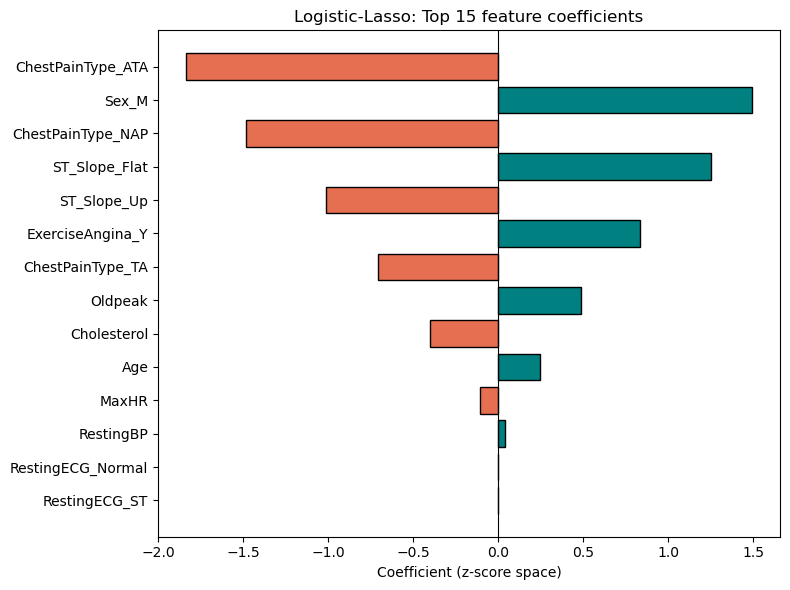

Figure saved to: Q1 FIGURES/Q2.4\log_lasso_feature_importance.png


In [3]:
# ============================================
# Q2.4 – Visualise coefficient importance
#         (and save figure)
# ============================================

import os, numpy as np, pandas as pd, joblib, matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

# ------------------------------------------------------------------
# 0)  Make sure output folder exists
# ------------------------------------------------------------------
FIG_DIR = "Q1 FIGURES/Q2.4"
os.makedirs(FIG_DIR, exist_ok=True)

# ------------------------------------------------------------------
# 1)  Re‑declare custom class so that pre‑processor unpickles cleanly
# ------------------------------------------------------------------
class KNNAndScaledBounds(BaseEstimator, TransformerMixin):
    def __init__(self, n_neighbors=5, raw_min_dict=None):
        self.n_neighbors  = n_neighbors
        self.raw_min_dict = raw_min_dict or {1: 50, 2: 70, 4: 0}

    def fit(self, X, y=None):
        self.n_features_ = X.shape[1]
        self.scaler_     = StandardScaler().fit(X)
        Xs               = self.scaler_.transform(X)

        self.imputer_    = KNNImputer(n_neighbors=self.n_neighbors).fit(Xs)

        self.scaled_min_ = {}
        for idx, raw_min in self.raw_min_dict.items():
            mean, scale            = self.scaler_.mean_[idx], self.scaler_.scale_[idx]
            self.scaled_min_[idx]  = (raw_min - mean) / scale
        return self

    def transform(self, X, y=None):
        if X.shape[1] != self.n_features_:
            raise ValueError("Unexpected number of features")
        Xs  = self.scaler_.transform(X)
        Xsi = self.imputer_.transform(Xs)
        for idx, zmin in self.scaled_min_.items():
            Xsi[:, idx] = np.clip(Xsi[:, idx], zmin, None)
        return self.scaler_.inverse_transform(Xsi)

# ------------------------------------------------------------------
# 2)  Load the fitted pipeline (pre‑processor + logistic‑lasso)
# ------------------------------------------------------------------
PIPE_PATH = "logreg_l1.pkl"          # created in Q2.1
pipe      = joblib.load(PIPE_PATH)

prep = pipe.named_steps["prep"]
clf  = pipe.named_steps["clf"]

# ------------------------------------------------------------------
# 3)  Recover *final* feature names (after one‑hot)
# ------------------------------------------------------------------
num_cols = prep.transformers_[0][2]
ohe      = prep.named_transformers_["cat"].named_steps["onehot"]
cat_cols = ohe.get_feature_names_out(
    ["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope"])
feat_names = np.concatenate([num_cols, cat_cols])

# ------------------------------------------------------------------
# 4)  Build DataFrame of coefficients
# ------------------------------------------------------------------
coefs   = clf.coef_.flatten()
coef_df = (pd.DataFrame({"Feature": feat_names,
                         "Coefficient": coefs,
                         "|coef|": np.abs(coefs)})
             .sort_values("|coef|", ascending=False)
             .reset_index(drop=True))

# ------------------------------------------------------------------
# 5)  Plot – horizontal bar‑chart (top 15 by magnitude) & save
# ------------------------------------------------------------------
TOP_N = 15
top_df = coef_df.head(TOP_N)[::-1]    # reverse for nicer plotting order

plt.figure(figsize=(8, 6))
colors = top_df["Coefficient"].apply(lambda v: "#008080" if v > 0 else "#e76f51")
plt.barh(top_df["Feature"], top_df["Coefficient"],
         color=colors, edgecolor="black")
plt.axvline(0, color="k", lw=0.8)
plt.title(f"Logistic‑Lasso: Top {TOP_N} feature coefficients")
plt.xlabel("Coefficient (z‑score space)")
plt.tight_layout()

fig_path = os.path.join(FIG_DIR, "log_lasso_feature_importance.png")
plt.savefig(fig_path, dpi=120)
plt.show()               # keeps the plot visible in the notebook
plt.close()

print(f"Figure saved to: {fig_path}")

### Q 2.4 – Reading the coefficient plot

The bars show each feature’s **signed coefficient** in the final z‑score space:

| Sign | Interpretation (holding every other feature constant) |
|------|-------------------------------------------------------|
| **Positive ( > 0, teal)** | A **one‑SD increase** in that feature **raises** the model’s log‑odds of *HeartDisease = 1*.  <br>For one‑hot dummies it means “having this level (vs. the baseline) pushes the prediction **towards** disease”. |
| **Negative ( < 0, coral)** | A one‑SD increase (or “having this category”) **lowers** the log‑odds – i.e. the model moves **away from** the disease class. |

Because every numeric column was z‑scaled (mean 0, SD 1) **and** each category is a 0/1 flag, the magnitude of a bar is directly comparable across all variables.

---

#### What the model is telling us

* **ChestPainType_ATA (β ≈ –2.0)**  
  The “*typical angina*” pattern is strongly *protective* relative to the baseline level (ASY = asymptomatic). Patients reporting ATA pain are much less likely to have underlying heart disease.

* **Sex_M (β ≈ +1.6)**  
  Being male shifts the prediction decisively **towards** disease, in line with epidemiology.

* **ST_Slope_Flat vs. ST_Slope_Up**  
  *Flat* slope is risky (β ≈ +1.3) whereas an *Up* slope is protective (β ≈ –1.0). These are classical ECG findings.

* **ExerciseAngina_Y (β ≈ +0.9)**  
  Exercise‑induced angina substantially increases the probability of disease.

* **Oldpeak (β ≈ +0.5 per SD)**  
  Higher ST‑depression after exercise moves the model towards the positive class.

* **Cholesterol (β ≈ –0.4 per SD)**  
  Surprisingly negative: once we control for the other variables, higher cholesterol slightly lowers predicted risk – a reminder that univariate intuition can flip after multivariable adjustment (or that the lasso zeroed out other collinear lipid markers).

Variables whose bars touch zero (e.g. `RestingECG_Normal`, `RestingECG_ST`) were **shrunk to zero** by the L1 penalty and play no role in the final decision rule.

---

> **Rule of thumb:**  
> *Positive β → raises log‑odds → pushes probability ↑*  
> *Negative β → lowers log‑odds → pushes probability ↓*  

# Q2.5 – Good or Bad Idea? Retraining Logistic on Lasso-Selected Features

A tempting workflow is:

1. **Run Logistic + L1 (lasso) on the full data → keep the non‑zero coefficients.**  
2. **Throw away the rest of the columns.**  
3. **Refit an *un‑penalised* logistic regression on this reduced set and publish those odds‑ratios.**

Below is a balanced view of why that *looks* attractive, and why it can quietly break the rules of honest inference.

| | **Why it *sounds* like a good idea** | **Why it can back‑fire** |
|---|---|---|
| **Simplicity & clarity** | A handful of predictors and clean odds‑ratios are easy to explain to clinicians or policy‑makers. | The variable list was chosen **inside** the data you’re now using for the final fit.  Standard errors and p‑values ignore this selection step → **confidence intervals are too narrow, effects look “significant” when they’re not** (post‑selection bias). |
| **Removes shrinkage bias** | L1 pulls surviving coefficients toward 0; refitting without the penalty lets them bounce back to their MLE values. | That shrinkage is what tamed over‑fit in the first place.  Dropping it often **re‑inflates variance** and hurts test‑set performance (unless you use a proper “relaxed lasso” with a separated validation set). |
| **Keeps only the “important” variables** | If the lasso set β = 0 the feature must be useless right? | L1 is **unstable under collinearity**.  In another split it might flip and keep the correlated twin variable instead.  Throwing away “redundant” columns can distort the coefficients of those that remain (omitted‑variable bias). |
| **Faster to run** | Smaller design matrix ⇒ quicker training. | Trivial speed‑ups nowadays; not worth the statistical risk. |

#### When *could* it be acceptable?
* **Nested cross‑validation** or an **external test set**:  
  Select variables on the *inner* folds, refit on each inner‑train fold, and judge performance on untouched data.  That preserves the training/validation firewall.
* **Post‑selection inference tools** (e.g. Lee et al., 2016):  
  These adjust p‑values and CIs after lasso selection, but require specialised software and care.

#### Bottom line
Using the lasso purely as a feature screen **and then pretending you never did** is statistical “double‑dipping.”  
It can yield a neat‑looking table of odds‑ratios, but the apparent precision is illusory.  **Staying within the single, regularised pipeline, or adopting nested CV if you must refit, keeps your conclusions on solid ground.**


**Post‑selection inference reference:**
Lee, J. D., Sun, D. L., Sun, Y., & Taylor, J. E. (2016).  
*Exact post‑selection inference, with application to the lasso.* **Annals of Statistics, 44**(3), 907–927. https://doi.org/10.1214/15-AOS1371